In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
from tqdm import trange
from scipy.ndimage import convolve
from imageio.v2 import imread, imwrite
import numba

In [2]:
img_file = './img/flip-the-monkey.png'
out_file = './img/flip-the-monkey-carved.png'

In [3]:
img_array = cv.imread(img_file)

In [4]:
img_array = cv.cvtColor(img_array, cv.COLOR_BGR2RGB)

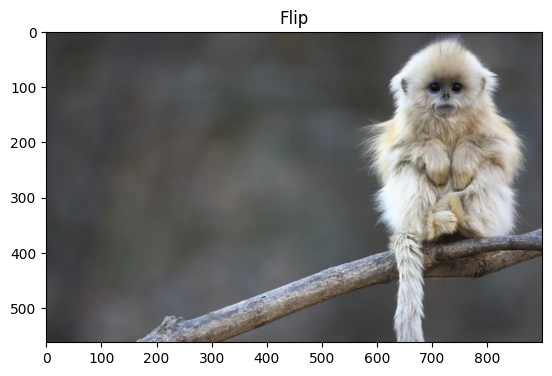

In [5]:
plt.imshow(img_array)
plt.title("Flip")
plt.show()

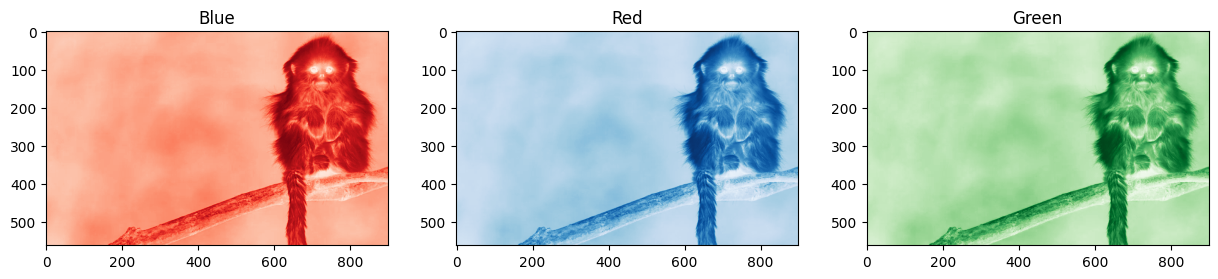

In [6]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

axs[0].imshow(img_array[:, :, 0], cmap="Reds")
axs[0].set_title("Blue")

axs[1].imshow(img_array[:, :, 1], cmap="Blues")
axs[1].set_title("Red")

axs[2].imshow(img_array[:, :, 2], cmap="Greens")
axs[2].set_title("Green")

plt.show()

## Blurring

In [7]:
img_blur = cv.blur(img_array, (5,5))

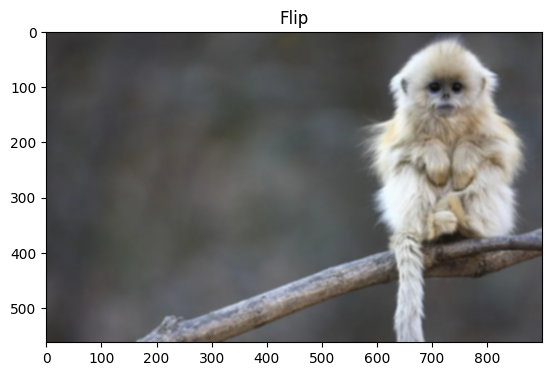

In [8]:
plt.imshow(img_blur)
plt.title("Flip")
plt.show()

## Sharpening

In [9]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharp = cv.filter2D(img_array, -1, kernel)

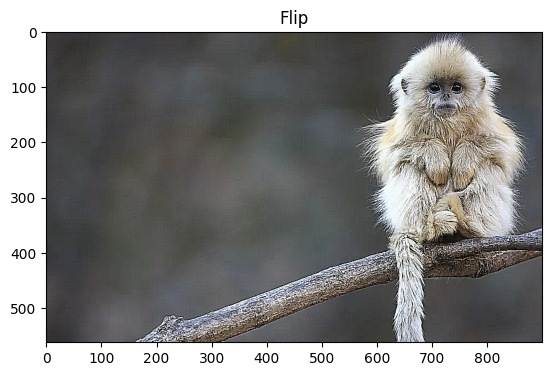

In [10]:
plt.imshow(img_sharp)
plt.title("Flip")
plt.show()

In [29]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map


def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)

    return img


def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img


def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img


def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [30]:
def main(img_axis, img_scale, image_src, image_dest):
    which_axis = img_axis
    scale = img_scale
    in_filename = image_src
    out_filename = image_dest

    img = imread(in_filename)
    if which_axis == 'r':
        out = crop_r(img, scale)
    elif which_axis == 'c':
        out = crop_c(img, scale)
    
    imwrite(out_filename, out)

In [32]:
main('c', 0.5, image_src=img_file, image_dest=out_file)

100%|█████████████████████████████████████████| 450/450 [05:55<00:00,  1.26it/s]
